In [258]:
ls

2Autoencoder.ipynb        lens_1000_no_sc.h5        LSST_EUCLID.ipynb
Dark_satelite2.ipynb      lens_10k_no_sc.h5         LSST_generator.py
Dark_satelite.ipynb       lens_2000_no_sc.h5        VAE.ipynb
generator_LSST.ipynb      lens_dataset_2000.h5      VAE_LSST_1}.ipynb
generator_notebook.ipynb  lens_dataset.h5           VAE_LSST.ipynb
generator.py              lens_dataset_lsst_rgb.h5


In [259]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.utils.data import TensorDataset
from tqdm import trange

import torch.nn.functional as F

Available datasets: ['delta_psi_maps', 'images_clean', 'images_rgb', 'subhalo_mass', 'subhalo_x', 'subhalo_y']
images_rgb shape: (500, 40, 40, 3)
images_clean shape: (500, 40, 40, 3)
delta_psi_maps shape: (500, 40, 40)
subhalo_mass shape: (500,)
subhalo_x shape: (500,)
subhalo_y shape: (500,)
Plotting samples: [173  53 132]


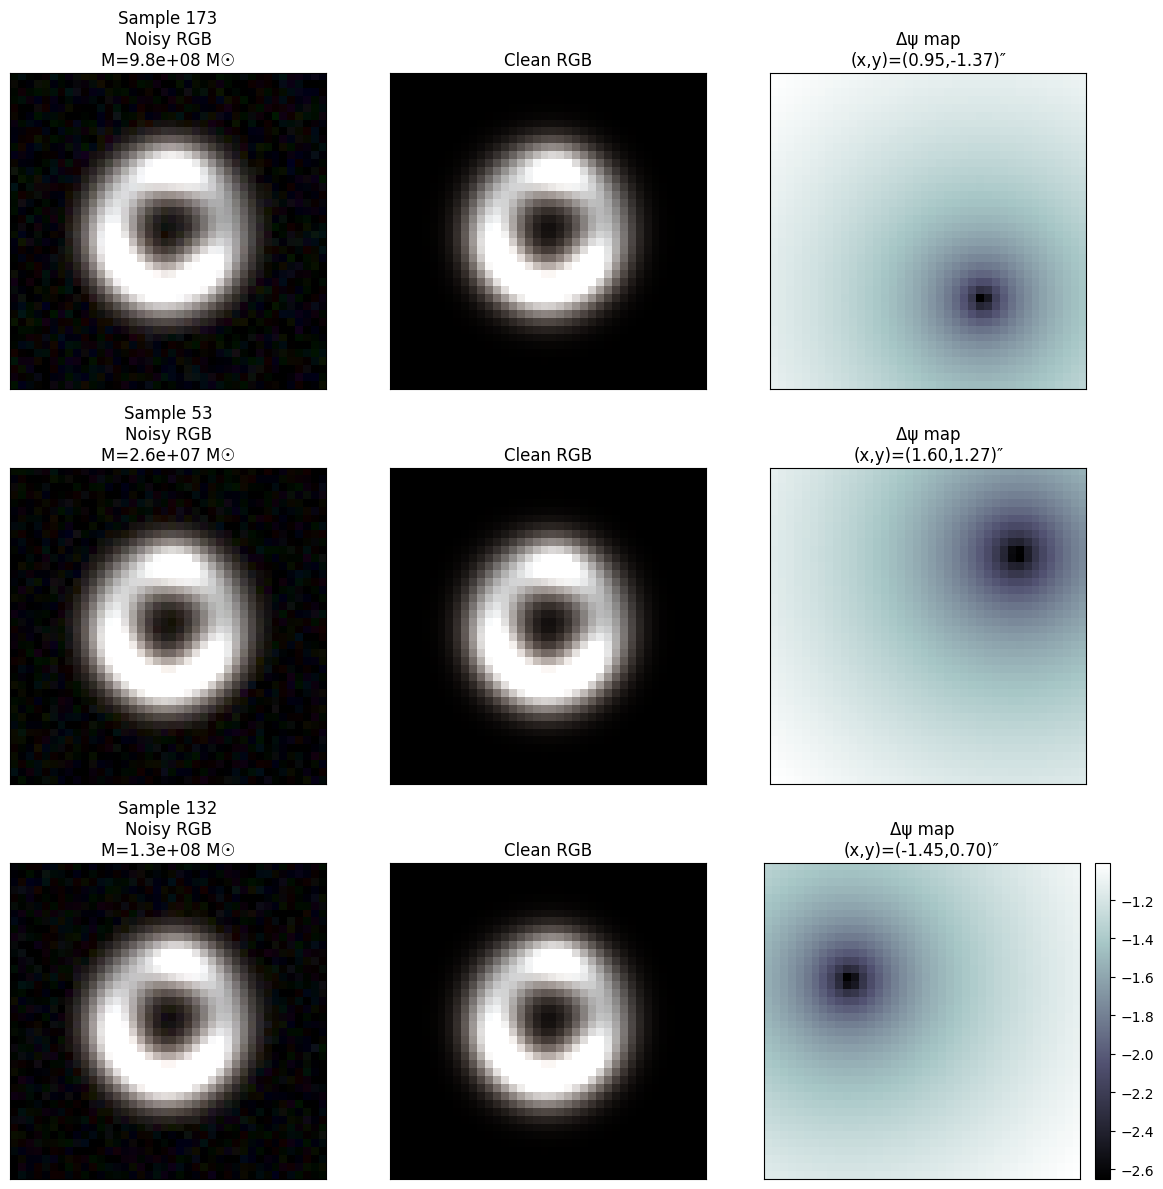

In [260]:
# Path to the new RGB HDF5 dataset
h5_path = 'lens_dataset_lsst_rgb.h5'

with h5py.File(h5_path, 'r') as f:
    print("Available datasets:", list(f.keys()))
    print("images_rgb shape:", f['images_rgb'].shape)
    print("images_clean shape:", f['images_clean'].shape)
    print("delta_psi_maps shape:", f['delta_psi_maps'].shape)
    print("subhalo_mass shape:", f['subhalo_mass'].shape)
    print("subhalo_x shape:", f['subhalo_x'].shape)
    print("subhalo_y shape:", f['subhalo_y'].shape)

    # Choose three random sample indices
    N = f['images_rgb'].shape[0]
    sample_indices = np.random.choice(N, size=3, replace=False)
    print("Plotting samples:", sample_indices)

    # Create figure with 3 rows and 3 columns
    fig, axes = plt.subplots(3, 3, figsize=(12, 12), sharex=True, sharey=True)

    for row, idx in enumerate(sample_indices):
        img_rgb     = f['images_rgb'][idx]    # shape (ny, nx, 3)
        img_clean   = f['images_clean'][idx]  # shape (ny, nx, 3)
        delta_psi   = f['delta_psi_maps'][idx]
        mass        = f['subhalo_mass'][idx]
        x_sub, y_sub = f['subhalo_x'][idx], f['subhalo_y'][idx]

        # Panel 1: RGB image with noise
        axes[row, 0].imshow(img_rgb, origin='lower')
        axes[row, 0].set_title(f"Sample {idx}\nNoisy RGB\nM={mass:.1e} M☉")

        # Panel 2: RGB image clean (no subhalo, no noise)
        axes[row, 1].imshow(img_clean, origin='lower')
        axes[row, 1].set_title("Clean RGB")

        # Panel 3: Δψ map
        im2 = axes[row, 2].imshow(delta_psi, origin='lower', cmap='bone')
        axes[row, 2].set_title(f"Δψ map\n(x,y)=({x_sub:.2f},{y_sub:.2f})″")

        # Colorbar only for Δψ on the last row
        if row == 2:
            fig.colorbar(im2, ax=axes[row, 2], fraction=0.046, pad=0.04)

    for ax in axes.flatten():
        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()
    plt.show()


In [261]:
# 1) Load the data from the HDF5 file
with h5py.File(h5_path, 'r') as f:
    X_noisy  = f['images_rgb'][:]    # (N, H, W, 3)
    Y_smooth = f['images_clean'][:]   # (N, H, W, 3)
    Y_delta  = f['delta_psi_maps'][:]  # (N, H, W, 3)
    sub_mass = f['subhalo_mass'][:]  # (N,)
    sub_x    = f['subhalo_x'][:]     # (N,)
    sub_y    = f['subhalo_y'][:]     # (N,)

In [262]:
X_noisy.shape

(500, 40, 40, 3)

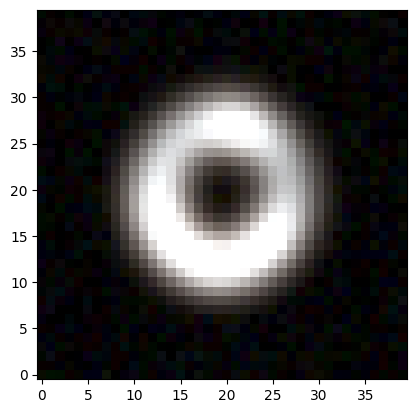

In [263]:
plt.imshow(X_noisy[0], origin='lower')

### Step 2: Pre-processing

We first remove any invalid entries (NaN or ±Inf), then wrap the arrays into PyTorch tensors and add the channel dimension.




In [264]:
# 2) Clean the data (mismo que antes)
X_noisy = np.nan_to_num(X_noisy, nan=0.0, posinf=None, neginf=None)
Y_smooth = np.nan_to_num(Y_smooth, nan=0.0, posinf=None, neginf=None)
Y_delta  = np.nan_to_num(Y_delta,  nan=0.0, posinf=None, neginf=None)
sub_mass = np.nan_to_num(sub_mass, nan=0.0, posinf=None, neginf=None)
sub_x    = np.nan_to_num(sub_x,    nan=0.0, posinf=None, neginf=None)
sub_y    = np.nan_to_num(sub_y,    nan=0.0, posinf=None, neginf=None)

# 3) Convertir a tensores en formato channel-first
# X_noisy: (N, H, W, 3) -> (N, 3, H, W)
X  = torch.from_numpy(X_noisy).permute(0, 3, 1, 2).float()

# Y_smooth: si también es RGB (N, H, W, 3) -> (N, 3, H, W)
Y1 = torch.from_numpy(Y_smooth).permute(0, 3, 1, 2).float()

# Y_delta: 1 canal (N, H, W) -> (N, 1, H, W)
Y2 = torch.from_numpy(Y_delta).float().unsqueeze(1)


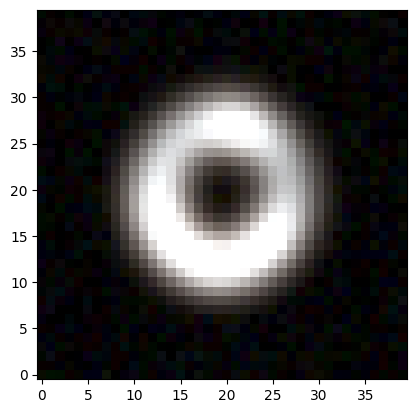

In [265]:
plt.imshow(X[0].permute(1, 2, 0).numpy(), origin='lower')

In [266]:
#Split the data into training, validation, and test sets
# 1) Índices para cada subconjunto
idx = np.arange(X.shape[0])

# 10% para test
idx_rest, idx_test = train_test_split(idx, test_size=0.10, random_state=42)

# De lo que queda (90%), separar 20% para validación → equivale a 2/9 ≈ 22.22%
idx_train, idx_val = train_test_split(idx_rest, test_size=2/9, random_state=42)

# 2) Split de imágenes
X_train, X_val, X_test   = X[idx_train],  X[idx_val],  X[idx_test]
Y1_train, Y1_val, Y1_test = Y1[idx_train], Y1[idx_val], Y1[idx_test]
Y2_train, Y2_val, Y2_test = Y2[idx_train], Y2[idx_val], Y2[idx_test]

# 3) Split de masa y coordenadas
sub_mass_train, sub_mass_val, sub_mass_test = sub_mass[idx_train], sub_mass[idx_val], sub_mass[idx_test]
sub_x_train, sub_x_val, sub_x_test = sub_x[idx_train], sub_x[idx_val], sub_x[idx_test]
sub_y_train, sub_y_val, sub_y_test = sub_y[idx_train], sub_y[idx_val], sub_y[idx_test]

In [267]:
#Visualización de los datos
def describe_tensor(t, name):
    print(f"--- {name} ---")
    print("Shape:", t.shape)
    print("Min:", t.min().item())
    print("Max:", t.max().item())
    print("Mean:", t.mean().item())
    print("Std:", t.std().item())
    print("Median:", t.median().item())
    print("Percentiles [0.1, 1, 25, 50, 75, 99, 99.9]:", np.percentile(t.cpu().numpy().flatten(), [0.1, 1, 25, 50, 75, 99, 99.9]))
    print()

describe_tensor(X_train, "X_train (Noisy RGB)")
describe_tensor(Y1_train, "Y1_train (Clean RGB)")
describe_tensor(Y2_train, "Y2_train (Δψ)")


--- X_train (Noisy RGB) ---
Shape: torch.Size([350, 3, 40, 40])
Min: 0.0
Max: 1.0
Mean: 0.19157107174396515
Std: 0.3041611611843109
Median: 0.04324369505047798
Percentiles [0.1, 1, 25, 50, 75, 99, 99.9]: [0.         0.         0.         0.04324375 0.21727701 1.
 1.        ]

--- Y1_train (Clean RGB) ---
Shape: torch.Size([350, 3, 40, 40])
Min: 1.5442640943774677e-08
Max: 1.0
Mean: 0.17884907126426697
Std: 0.3086007237434387
Median: 0.004070228431373835
Percentiles [0.1, 1, 25, 50, 75, 99, 99.9]: [1.79596533e-08 7.60655809e-08 1.03040056e-04 4.07052878e-03
 2.14692745e-01 1.00000000e+00 1.00000000e+00]

--- Y2_train (Δψ) ---
Shape: torch.Size([350, 1, 40, 40])
Min: -2.9905447959899902
Max: -0.5632624626159668
Mean: -1.4646451473236084
Std: 0.3620724081993103
Median: -1.4563411474227905
Percentiles [0.1, 1, 25, 50, 75, 99, 99.9]: [-2.68523007 -2.36121546 -1.71557254 -1.45634031 -1.19207299 -0.7712641
 -0.68081292]



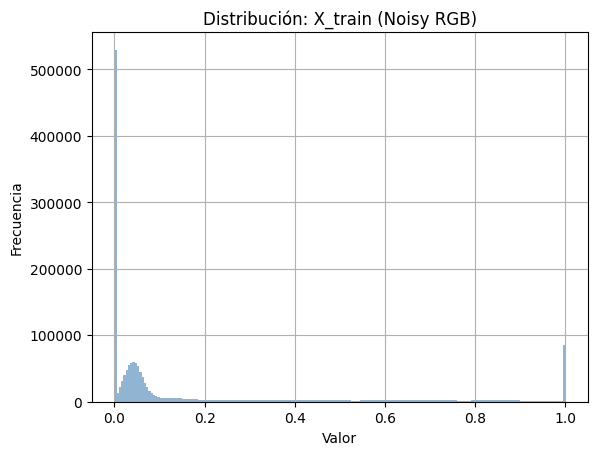

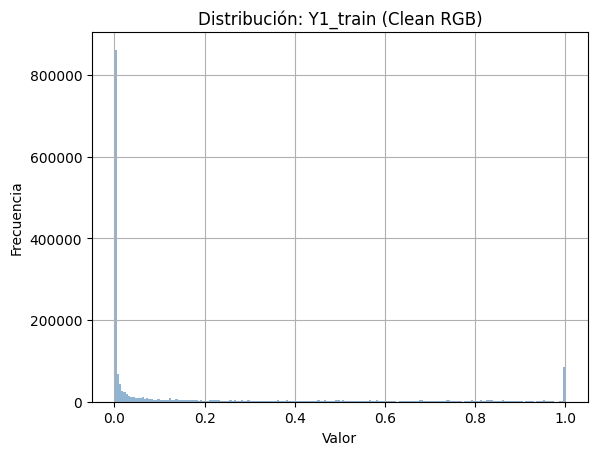

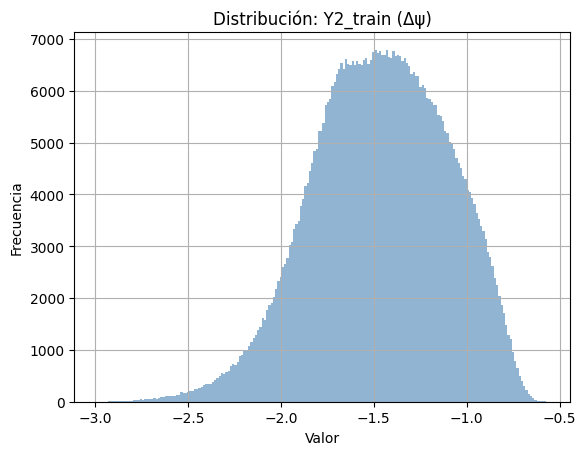

In [268]:
#Histograma de las variables
def plot_histogram(tensor, title, bins=200):
    t_np = tensor.cpu().numpy().flatten()
    plt.hist(t_np, bins=bins, alpha=0.6, color='steelblue')
    plt.title(title)
    plt.xlabel("Valor")
    plt.ylabel("Frecuencia")
    plt.grid(True)
    plt.show()

plot_histogram(X_train, "Distribución: X_train (Noisy RGB)")
plot_histogram(Y1_train, "Distribución: Y1_train (Clean RGB)")
plot_histogram(Y2_train, "Distribución: Y2_train (Δψ)")


In [269]:
mean_Y2 = Y2_train.mean().item()
std_Y2 = Y2_train.std().item()

Y2_train = (Y2_train - mean_Y2) / std_Y2
Y2_val   = (Y2_val   - mean_Y2) / std_Y2
Y2_test  = (Y2_test  - mean_Y2) / std_Y2

# --- Asegurar conversión a tensores ---
sub_mass_train = torch.tensor(sub_mass_train).float()
sub_mass_val   = torch.tensor(sub_mass_val).float()
sub_mass_test  = torch.tensor(sub_mass_test).float()

sub_x_train = torch.tensor(sub_x_train).float()
sub_x_val   = torch.tensor(sub_x_val).float()
sub_x_test  = torch.tensor(sub_x_test).float()


sub_y_train = torch.tensor(sub_y_train).float()
sub_y_val   = torch.tensor(sub_y_val).float()
sub_y_test  = torch.tensor(sub_y_test).float()

# --- Agrupar y normalizar ---
mxy_train = torch.stack([sub_mass_train, sub_x_train, sub_y_train], dim=1)
mxy_val   = torch.stack([sub_mass_val,   sub_x_val,   sub_y_val],   dim=1)
mxy_test  = torch.stack([sub_mass_test,  sub_x_test,  sub_y_test],  dim=1)

mean_mxy = mxy_train.mean(dim=0)
std_mxy  = mxy_train.std(dim=0)

mxy_train = (mxy_train - mean_mxy) / std_mxy
mxy_val   = (mxy_val   - mean_mxy) / std_mxy
mxy_test  = (mxy_test  - mean_mxy) / std_mxy


In [270]:
# ✅ Estadísticas que sí necesitas guardar:
# 1. Para desnormalizar Y2 (Δψ map):

# Como estás usando z-score:
# mean_Y2 = Y2_train.mean().item()
# std_Y2 = Y2_train.std().item()

# 2. Para desnormalizar mxy (masa, x, y):
# mean_mxy = mxy_train.mean(dim=0)  # tensor([mean_mass, mean_x, mean_y])
# std_mxy = mxy_train.std(dim=0)    # tensor([std_mass, std_x, std_y])

norm_stats = {
    "mean_Y2": mean_Y2,
    "std_Y2": std_Y2,
    "mean_mass": mean_mxy[0].item(),
    "std_mass":  std_mxy[0].item(),
    "mean_x":    mean_mxy[1].item(),
    "std_x":     std_mxy[1].item(),
    "mean_y":    mean_mxy[2].item(),
    "std_y":     std_mxy[2].item()
}


### Normalization

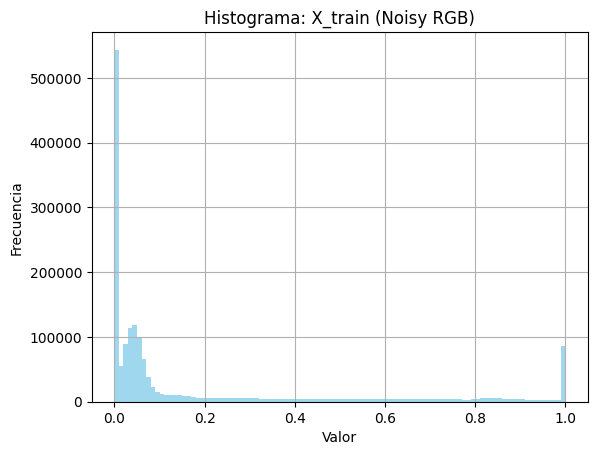

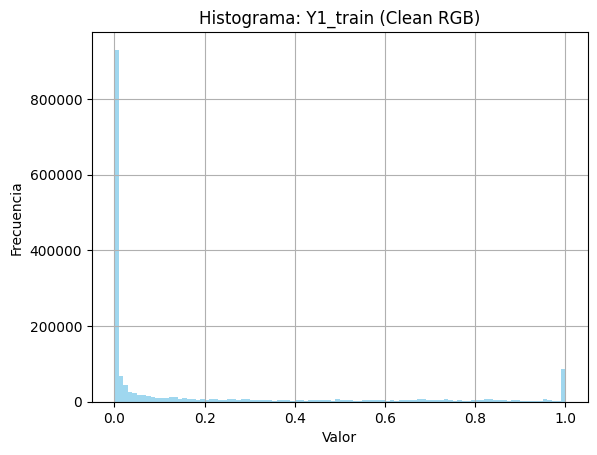

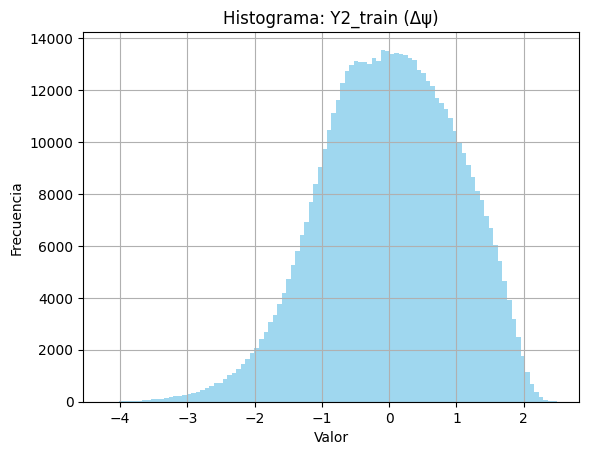

In [271]:
def plot_histogram(tensor, name):
    flat = tensor.detach().cpu().numpy().flatten()
    plt.hist(flat, bins=100, color='skyblue', alpha=0.8)
    plt.title(f"Histograma: {name}")
    plt.xlabel("Valor")
    plt.ylabel("Frecuencia")
    plt.grid(True)
    plt.show()

plot_histogram(X_train, "X_train (Noisy RGB)")
plot_histogram(Y1_train, "Y1_train (Clean RGB)")
plot_histogram(Y2_train, "Y2_train (Δψ)")


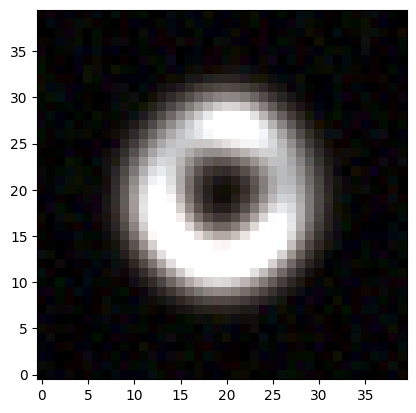

In [272]:
plt.imshow(X_train[0].permute(1, 2, 0).numpy(), origin='lower')

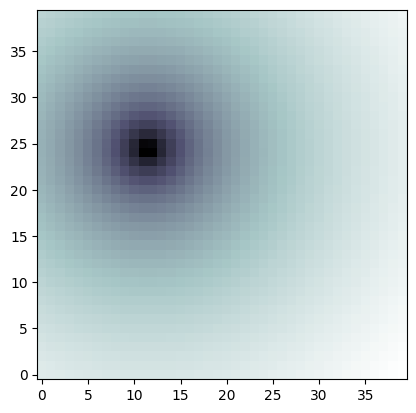

In [273]:
plt.imshow(Y2_train[0,0].numpy(), origin='lower', cmap='bone')  

### 📦 7) Dataset and DataLoader

This section prepares the datasets and data loaders used during training, validation, and testing.

---

#### 🔹 1) Create TensorDatasets

We package the input and target tensors into `TensorDataset` objects. This allows us to efficiently iterate through the data during training and evaluation.

```python
train_ds = TensorDataset(X_train, Y1_train, Y2_train, mxy_train)
val_ds   = TensorDataset(X_val,   Y1_val,   Y2_val, mxy_val)


In [ ]:
from torch.utils.data import TensorDataset, DataLoader
import torch

batch = 32  # Tamaño del batch
on_cuda = torch.cuda.is_available()

# 1) Datasets
train_ds = TensorDataset(X_train, Y1_train, Y2_train, mxy_train)
val_ds   = TensorDataset(X_val,   Y1_val,   Y2_val,   mxy_val)
test_ds  = TensorDataset(X_test,  Y1_test,  Y2_test,  mxy_test)

# 2) DataLoaders
common_kwargs = dict(
    batch_size=batch,
    num_workers=4,
    pin_memory=on_cuda,
    persistent_workers=True
)

train_loader = DataLoader(
    train_ds,
    shuffle=True,
    drop_last=True,
    **common_kwargs
)

val_loader = DataLoader(
    val_ds,
    shuffle=False,
    drop_last=False,
    **common_kwargs
)

test_loader = DataLoader(
    test_ds,
    shuffle=False,
    drop_last=False,
    **common_kwargs
)


In [275]:
g = torch.Generator()
g.manual_seed(42)
train_loader = DataLoader(train_ds, shuffle=True, generator=g, drop_last=True, **common_kwargs)

In [276]:
# Device
# 1) Detectar device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


🧠 DualVAE: Variational Autoencoder with Physical Regression

This model is a **Variational Autoencoder (VAE)** designed to process gravitational lensing data. It performs:

- **Dual reconstruction**:
  - A smooth background light source.
  - A lensing potential perturbation map (ΔΨ).
- **Regression of physical parameters**:
  - Subhalo **mass**, **x-position**, and **y-position**.

---

#### 🔹 Encoder

The encoder consists of **3 convolutional layers** with:
- 3×3 kernel, stride 2, padding 1 (downsampling by 8× total),
- ReLU activations,
- Dropout for regularization (`p=0.3`).

These layers transform the input image into a feature map, which is then flattened and projected into the latent space using two linear layers:
- `fc_mu` → mean vector `μ` (for latent variable)
- `fc_logvar` → log variance `logσ²`

---

#### 🔹 Latent Space & Sampling

To enable backpropagation through stochastic sampling, the model uses the **reparameterization trick**:

```python
z = mu + eps * std

self.fc_regs = nn.Sequential(
    nn.Linear(z_dim, z_dim // 2),
    nn.Tanh(),
    nn.Dropout(0.1),
    nn.Linear(z_dim // 2, 3)
)


In [277]:
class DualVAE(nn.Module):
    def __init__(self, in_ch=3, base_ch=16, z_dim=128, H=40, W=40):
        super().__init__()

        # ——— Encoder (3 convs stride=2) → (H/8, W/8) = (5,5) si H=W=40
        self.enc = nn.Sequential(
            nn.Conv2d(in_ch,     base_ch,   3, 2, 1), nn.ReLU(), nn.Dropout(0.2),
            nn.Conv2d(base_ch,   base_ch*2, 3, 2, 1), nn.ReLU(), nn.Dropout(0.2),
            nn.Conv2d(base_ch*2, base_ch*4, 3, 2, 1), nn.ReLU(), nn.Dropout(0.2),
        )

        # Tamaños tras las 3 convs (para 40→20→10→5)
        def conv_out(sz): return (sz + 2*1 - 3)//2 + 1
        H1, W1 = conv_out(H),    conv_out(W)   # 20
        H2, W2 = conv_out(H1),   conv_out(W1)  # 10
        H3, W3 = conv_out(H2),   conv_out(W2)  # 5

        self._C3 = 4 * base_ch
        self._H3 = H3
        self._W3 = W3
        feat_dim = self._C3 * H3 * W3

        # ——— VAE stats
        self.fc_mu     = nn.Linear(feat_dim, z_dim)
        self.fc_logvar = nn.Linear(feat_dim, z_dim)

        # ——— z → feature map
        self.fc_dec = nn.Linear(z_dim, feat_dim)

        # Decoder para imagen suave (3 canales RGB)
        self.decoder_s = nn.Sequential(
            nn.ReLU(),
            nn.Unflatten(1, (self._C3, self._H3, self._W3)),
            nn.ConvTranspose2d(self._C3,   self._C3//2, 3, 2, 1, output_padding=1),
            nn.ReLU(), nn.Dropout(0.1),
            nn.ConvTranspose2d(self._C3//2, base_ch,    3, 2, 1, output_padding=1),
            nn.ReLU(), nn.Dropout(0.1),
            nn.ConvTranspose2d(base_ch,     3,          3, 2, 1, output_padding=1),
            #nn.Sigmoid(),  # ← asegúrate que esté si tu salida RGB está en [0,1]
            nn.Upsample(size=(40, 40), mode='bilinear', align_corners=False)
        )

        # Decoder para Δψ (1 canal)
        self.decoder_d = nn.Sequential(
            nn.ReLU(),
            nn.Unflatten(1, (self._C3, self._H3, self._W3)),
            nn.ConvTranspose2d(self._C3,   self._C3//2, 3, 2, 1, output_padding=1),
            nn.ReLU(), nn.Dropout(0.1),
            nn.ConvTranspose2d(self._C3//2, base_ch,    3, 2, 1, output_padding=1),
            nn.ReLU(), nn.Dropout(0.1),
            nn.ConvTranspose2d(base_ch,     1,          3, 2, 1, output_padding=1),
            nn.Upsample(size=(40, 40), mode='bilinear', align_corners=False)
        )


        # ——— Cabezal de regresión (m, x, y) desde μ
        self.fc_regs = nn.Sequential(
            nn.Linear(z_dim, z_dim//2),
            nn.Tanh(), nn.Dropout(0.1),
            nn.Linear(z_dim//2, 3)
        )

    def encode(self, x):
        h = self.enc(x)
        h = h.view(h.size(0), -1)
        mu, logvar = self.fc_mu(h), self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = (0.5 * logvar).exp()
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.fc_dec(z)
        s = self.decoder_s(h)  # (N, 3, 40, 40)
        d = self.decoder_d(h)  # (N, 1, 40, 40)
        return s, d

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        s, d = self.decode(z)
        mxy_pred = self.fc_regs(mu)  # (N, 3)
        return s, d, mu, logvar, mxy_pred


In [ ]:
model = DualVAE(in_ch=3, base_ch=20, z_dim=128, H=40, W=40).to(device)


In [279]:
print(model)

DualVAE(
  (enc): Sequential(
    (0): Conv2d(3, 20, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Conv2d(20, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Conv2d(40, 80, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
  )
  (fc_mu): Linear(in_features=2000, out_features=256, bias=True)
  (fc_logvar): Linear(in_features=2000, out_features=256, bias=True)
  (fc_dec): Linear(in_features=256, out_features=2000, bias=True)
  (decoder_s): Sequential(
    (0): ReLU()
    (1): Unflatten(dim=1, unflattened_size=(80, 5, 5))
    (2): ConvTranspose2d(80, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): Dropout(p=0.1, inplace=False)
    (5): ConvTranspose2d(40, 20, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (6): R

In [280]:
# 3.3) Optimizer (puede quedarse igual)
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.001,  # learning rate
    weight_decay=1e-4
)

In [281]:
# # Loss function for the VAE and regression (adapted for RGB input)
# def combined_loss(s_pred, s_true,
#                   d_pred, d_true,
#                   mu, logvar,
#                   mxy_pred, mxy_true,
#                   alpha=1.0, beta=1e-3, gamma=1.0):
#     """
#     Combined loss for multitask VAE:
#     - Reconstruction loss for smooth image and Δψ map
#     - KL divergence for latent space regularization
#     - Regression loss for mass and position (m, x, y)

#     Args:
#         s_pred, s_true: Predicted and ground truth smooth images  (B, C, H, W)
#         d_pred, d_true: Predicted and ground truth Δψ images      (B, 1, H, W)
#         mu, logvar: Mean and log-variance from encoder
#         mxy_pred, mxy_true: Predicted and ground truth (m, x, y)  (B, 3)
#         alpha: weight for Δψ reconstruction loss
#         beta:  weight for KL divergence
#         gamma: weight for regression loss
#     """
#     # Reconstruction loss (smooth + alpha*Δψ)
#     recon = F.mse_loss(s_pred, s_true) + alpha * F.mse_loss(d_pred, d_true)

#     # KL divergence
#     kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
#     kl /= s_pred.size(0)

#     vae_l = recon + beta * kl

#     # Regression loss for (m, x, y)
#     reg_l = F.mse_loss(mxy_pred, mxy_true)

#     return vae_l + gamma * reg_l

##### otra versión del costo ######
def combined_loss(s_pred, s_true,
                  d_pred, d_true,
                  mu, logvar,
                  mxy_pred, mxy_true,
                  alpha=1.0, beta=1e-3, gamma=1.0):
    """
    Combined loss for multitask VAE.
    """
    # Reconstruction loss (RGB + alpha * Δψ)
    recon_rgb = F.mse_loss(s_pred, s_true)
    recon_d   = F.mse_loss(d_pred, d_true)
    recon = recon_rgb + alpha * recon_d

    # KL divergence (average over batch * z_dim)
    kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    # Regression loss
    reg = F.mse_loss(mxy_pred, mxy_true)

    # Final loss
    total = recon + beta * kl + gamma * reg

    return total


In [282]:

# def train_epoch(loader, optimizer, alpha=1.0, beta=1e-3, gamma=1.0):
#     model.train()
#     running_loss = 0.0
#     for x, y_s, y_d, mxy in loader:
#         # non_blocking aprovecha pin_memory=True
#         x   = x.to(device, non_blocking=True)
#         y_s = y_s.to(device, non_blocking=True)
#         y_d = y_d.to(device, non_blocking=True)
#         mxy = mxy.to(device, non_blocking=True)

#         optimizer.zero_grad(set_to_none=True)

#         # AMP opcional (acelera en GPU, iguala en CPU)
#         with autocast(enabled=torch.cuda.is_available()):
#             p_s, p_d, mu, logvar, mxy_pred = model(x)
#             loss = combined_loss(p_s, y_s, p_d, y_d, mu, logvar, mxy_pred, mxy,
#                                  alpha, beta, gamma)

#         scaler.scale(loss).backward()
#         torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
#         scaler.step(optimizer)
#         scaler.update()

#         running_loss += loss.item() * x.size(0)

#     return running_loss / len(loader.dataset)
from torch.cuda.amp import autocast, GradScaler

scaler = GradScaler(enabled=torch.cuda.is_available())

# #versión 2 de train_epoch
# def train_epoch(loader, optimizer, alpha=1.0, beta=1e-3, gamma=1.0, log_batches=2):
#     model.train()
#     running_loss = 0.0

#     for i, (x, y_s, y_d, mxy) in enumerate(loader):
#         x   = x.to(device, non_blocking=True)
#         y_s = y_s.to(device, non_blocking=True)
#         y_d = y_d.to(device, non_blocking=True)
#         mxy = mxy.to(device, non_blocking=True)

#         optimizer.zero_grad(set_to_none=True)

#         with autocast(enabled=torch.cuda.is_available()):
#             p_s, p_d, mu, logvar, mxy_pred = model(x)

#             # Separar componentes
#             recon_s = F.mse_loss(p_s, y_s)
#             recon_d = F.mse_loss(p_d, y_d)
#             kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
#             reg = F.mse_loss(mxy_pred, mxy)

#             loss = recon_s + alpha * recon_d + beta * kl + gamma * reg

#         scaler.scale(loss).backward()
#         torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
#         scaler.step(optimizer)
#         scaler.update()

#         running_loss += loss.item() * x.size(0)

#         # Mostrar las primeras batches
#         if i < log_batches:
#             print(f"[Batch {i}] Loss: {loss.item():.4f} | Recon_s: {recon_s.item():.4f} | "
#                   f"Recon_d: {recon_d.item():.4f} | KL: {kl.item():.4f} | Reg: {reg.item():.4f}")

#     return running_loss / len(loader.dataset)

def train_epoch(loader, optimizer, alpha=1.0, beta=1e-3, gamma=1.0, log_batches=2):
    model.train()
    running_loss = 0.0

    for i, (x, y_s, y_d, mxy) in enumerate(loader):
        x   = x.to(device, non_blocking=True)
        y_s = y_s.to(device, non_blocking=True)
        y_d = y_d.to(device, non_blocking=True)
        mxy = mxy.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        with autocast(enabled=torch.cuda.is_available()):
            p_s, p_d, mu, logvar, mxy_pred = model(x)

            recon_s = F.mse_loss(p_s, y_s)
            recon_d = F.mse_loss(p_d, y_d)
            kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())  # ← CORREGIDO
            reg = F.mse_loss(mxy_pred, mxy)

            loss = recon_s + alpha * recon_d + beta * kl + gamma * reg

        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * x.size(0)

        if i < log_batches:
            print(f"[Batch {i}] Loss: {loss.item():.4f} | Recon_s: {recon_s.item():.4f} | "
                  f"Recon_d: {recon_d.item():.4f} | KL: {kl.item():.4f} | Reg: {reg.item():.4f}")

    return running_loss / len(loader.dataset)


def eval_epoch(loader, alpha=1.0, beta=1e-3, gamma=1.0):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for x, y_s, y_d, mxy in loader:
            x   = x.to(device, non_blocking=True)
            y_s = y_s.to(device, non_blocking=True)
            y_d = y_d.to(device, non_blocking=True)
            mxy = mxy.to(device, non_blocking=True)

            with autocast(enabled=torch.cuda.is_available()):
                p_s, p_d, mu, logvar, mxy_pred = model(x)
                loss = combined_loss(p_s, y_s, p_d, y_d, mu, logvar, mxy_pred, mxy,
                                     alpha, beta, gamma)

            running_loss += loss.item() * x.size(0)

    return running_loss / len(loader.dataset)


In [283]:
# Diagnóstico previo al entrenamiento
model.eval()
with torch.no_grad():
    x, y_s, y_d, mxy = next(iter(train_loader))
    x = x.to(device)
    y_s, y_d = y_s.to(device), y_d.to(device)

    s_pred, d_pred, *_ = model(x)

    print(f"s_pred: min={s_pred.min().item():.4f}, max={s_pred.max().item():.4f}")
    print(f"d_pred: min={d_pred.min().item():.4f}, max={d_pred.max().item():.4f}")
    print(f"y_s:    min={y_s.min().item():.4f}, max={y_s.max().item():.4f}")
    print(f"y_d:    min={y_d.min().item():.4f}, max={y_d.max().item():.4f}")


s_pred: min=-0.2377, max=0.2746
d_pred: min=-0.5029, max=-0.0631
y_s:    min=0.0000, max=1.0000
y_d:    min=-4.1656, max=2.3139


In [284]:
from tqdm import trange

# Training loop
num_epochs = 30
alpha = 2.0    # más peso a Δψ
beta  = 1e-4   # menor KL para evitar colapso latente
gamma = 1.0    # regression igual

train_losses = []
val_losses   = []

# barra externa por época
outer_bar = trange(1, num_epochs+1, desc="Epoch", ncols=110, colour="#0cfff3")

for epoch in outer_bar:
    train_loss = train_epoch(train_loader, optimizer, alpha, beta, gamma)
    val_loss   = eval_epoch(val_loader, alpha, beta, gamma)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    outer_bar.set_postfix(train=f"{train_loss:.4f}", val=f"{val_loss:.4f}")


Epoch:   0%|                                                                           | 0/30 [00:00<?, ?it/s]

[Batch 0] Loss: 2.9025 | Recon_s: 0.1335 | Recon_d: 0.9496 | KL: 0.0006 | Reg: 0.8698
[Batch 1] Loss: 3.3160 | Recon_s: 0.1313 | Recon_d: 1.0331 | KL: 0.0012 | Reg: 1.1185


Epoch:   3%|█▎                                       | 1/30 [00:01<00:32,  1.12s/it, train=3.0218, val=2.9774]

[Batch 0] Loss: 3.6512 | Recon_s: 0.1227 | Recon_d: 1.2073 | KL: 0.0005 | Reg: 1.1140
[Batch 1] Loss: 2.9646 | Recon_s: 0.1205 | Recon_d: 0.9666 | KL: 0.0006 | Reg: 0.9110


Epoch:   7%|██▋                                      | 2/30 [00:01<00:25,  1.11it/s, train=2.9371, val=2.9253]

[Batch 0] Loss: 3.4707 | Recon_s: 0.1135 | Recon_d: 1.1241 | KL: 0.0004 | Reg: 1.1089
[Batch 1] Loss: 3.2746 | Recon_s: 0.1123 | Recon_d: 1.0648 | KL: 0.0004 | Reg: 1.0328


Epoch:  10%|████                                     | 3/30 [00:02<00:22,  1.21it/s, train=2.9027, val=2.8826]

[Batch 0] Loss: 3.0774 | Recon_s: 0.1066 | Recon_d: 0.9706 | KL: 0.0004 | Reg: 1.0296
[Batch 1] Loss: 3.3114 | Recon_s: 0.1051 | Recon_d: 1.0135 | KL: 0.0004 | Reg: 1.1792


Epoch:  13%|█████▍                                   | 4/30 [00:03<00:20,  1.26it/s, train=2.8373, val=2.8445]

[Batch 0] Loss: 3.1162 | Recon_s: 0.1019 | Recon_d: 1.0298 | KL: 0.0004 | Reg: 0.9547
[Batch 1] Loss: 3.4430 | Recon_s: 0.1013 | Recon_d: 1.1069 | KL: 0.0005 | Reg: 1.1280


Epoch:  17%|██████▊                                  | 5/30 [00:04<00:19,  1.30it/s, train=2.7745, val=2.8154]

[Batch 0] Loss: 3.1262 | Recon_s: 0.0986 | Recon_d: 1.0350 | KL: 0.0006 | Reg: 0.9576
[Batch 1] Loss: 3.2095 | Recon_s: 0.0979 | Recon_d: 1.0020 | KL: 0.0007 | Reg: 1.1077


Epoch:  20%|████████▏                                | 6/30 [00:04<00:17,  1.36it/s, train=2.7966, val=2.7884]

[Batch 0] Loss: 2.9368 | Recon_s: 0.0958 | Recon_d: 0.8971 | KL: 0.0014 | Reg: 1.0468
[Batch 1] Loss: 2.9370 | Recon_s: 0.0948 | Recon_d: 0.9639 | KL: 0.0016 | Reg: 0.9144


Epoch:  23%|█████████▌                               | 7/30 [00:05<00:16,  1.37it/s, train=2.7413, val=2.7420]

[Batch 0] Loss: 2.9413 | Recon_s: 0.0917 | Recon_d: 0.9195 | KL: 0.0029 | Reg: 1.0106
[Batch 1] Loss: 3.0201 | Recon_s: 0.0904 | Recon_d: 0.9845 | KL: 0.0038 | Reg: 0.9608


Epoch:  27%|██████████▉                              | 8/30 [00:06<00:15,  1.39it/s, train=2.7620, val=2.6900]

[Batch 0] Loss: 2.9044 | Recon_s: 0.0821 | Recon_d: 0.9353 | KL: 0.0155 | Reg: 0.9517
[Batch 1] Loss: 3.1715 | Recon_s: 0.0799 | Recon_d: 0.9544 | KL: 0.0230 | Reg: 1.1829


Epoch:  30%|████████████▎                            | 9/30 [00:06<00:15,  1.38it/s, train=2.6998, val=2.6160]

[Batch 0] Loss: 3.3935 | Recon_s: 0.0610 | Recon_d: 1.0361 | KL: 0.0660 | Reg: 1.2603
[Batch 1] Loss: 2.8960 | Recon_s: 0.0558 | Recon_d: 0.9381 | KL: 0.0782 | Reg: 0.9640


Epoch:  33%|█████████████▎                          | 10/30 [00:07<00:14,  1.40it/s, train=2.6986, val=2.6348]

[Batch 0] Loss: 2.6992 | Recon_s: 0.0421 | Recon_d: 0.8262 | KL: 0.0891 | Reg: 1.0048
[Batch 1] Loss: 2.9972 | Recon_s: 0.0396 | Recon_d: 0.9576 | KL: 0.0912 | Reg: 1.0423


Epoch:  37%|██████████████▋                         | 11/30 [00:08<00:13,  1.43it/s, train=2.6703, val=2.5668]

[Batch 0] Loss: 2.6792 | Recon_s: 0.0339 | Recon_d: 0.8697 | KL: 0.0745 | Reg: 0.9060
[Batch 1] Loss: 2.7295 | Recon_s: 0.0322 | Recon_d: 0.8877 | KL: 0.0681 | Reg: 0.9219


Epoch:  40%|████████████████                        | 12/30 [00:08<00:12,  1.42it/s, train=2.5669, val=2.5433]

[Batch 0] Loss: 3.1982 | Recon_s: 0.0321 | Recon_d: 0.9976 | KL: 0.0829 | Reg: 1.1708
[Batch 1] Loss: 2.9717 | Recon_s: 0.0305 | Recon_d: 0.9736 | KL: 0.1029 | Reg: 0.9940


Epoch:  43%|█████████████████▎                      | 13/30 [00:09<00:12,  1.41it/s, train=2.6940, val=2.5454]

[Batch 0] Loss: 2.6406 | Recon_s: 0.0326 | Recon_d: 0.8528 | KL: 0.0690 | Reg: 0.9023
[Batch 1] Loss: 2.6666 | Recon_s: 0.0384 | Recon_d: 0.8570 | KL: 0.0549 | Reg: 0.9141


Epoch:  47%|██████████████████▋                     | 14/30 [00:10<00:11,  1.43it/s, train=2.6130, val=2.5433]

[Batch 0] Loss: 2.6056 | Recon_s: 0.0214 | Recon_d: 0.8765 | KL: 0.0499 | Reg: 0.8312
[Batch 1] Loss: 3.0470 | Recon_s: 0.0215 | Recon_d: 0.9589 | KL: 0.0534 | Reg: 1.1078


Epoch:  50%|████████████████████                    | 15/30 [00:11<00:10,  1.42it/s, train=2.5896, val=2.5060]

[Batch 0] Loss: 3.0250 | Recon_s: 0.0223 | Recon_d: 0.9519 | KL: 0.0668 | Reg: 1.0990
[Batch 1] Loss: 2.7065 | Recon_s: 0.0190 | Recon_d: 0.8453 | KL: 0.0706 | Reg: 0.9969


Epoch:  53%|█████████████████████▎                  | 16/30 [00:12<00:10,  1.30it/s, train=2.6065, val=2.4981]

[Batch 0] Loss: 2.5107 | Recon_s: 0.0254 | Recon_d: 0.8491 | KL: 0.0522 | Reg: 0.7871
[Batch 1] Loss: 2.8257 | Recon_s: 0.0265 | Recon_d: 0.8831 | KL: 0.0454 | Reg: 1.0330


Epoch:  57%|██████████████████████▋                 | 17/30 [00:13<00:10,  1.18it/s, train=2.5477, val=2.4948]

[Batch 0] Loss: 2.5433 | Recon_s: 0.0159 | Recon_d: 0.8092 | KL: 0.0637 | Reg: 0.9090
[Batch 1] Loss: 2.7776 | Recon_s: 0.0205 | Recon_d: 0.8730 | KL: 0.0815 | Reg: 1.0111


Epoch:  60%|████████████████████████                | 18/30 [00:14<00:10,  1.11it/s, train=2.5201, val=2.4237]

[Batch 0] Loss: 3.1348 | Recon_s: 0.0136 | Recon_d: 1.0175 | KL: 0.0943 | Reg: 1.0860
[Batch 1] Loss: 2.8418 | Recon_s: 0.0139 | Recon_d: 0.8905 | KL: 0.0893 | Reg: 1.0470


Epoch:  63%|█████████████████████████▎              | 19/30 [00:15<00:10,  1.01it/s, train=2.5258, val=2.4425]

[Batch 0] Loss: 3.2236 | Recon_s: 0.0159 | Recon_d: 1.0386 | KL: 0.0938 | Reg: 1.1306
[Batch 1] Loss: 2.5340 | Recon_s: 0.0123 | Recon_d: 0.8008 | KL: 0.1117 | Reg: 0.9201


Epoch:  67%|██████████████████████████▋             | 20/30 [00:16<00:10,  1.01s/it, train=2.4830, val=2.4302]

[Batch 0] Loss: 2.6629 | Recon_s: 0.0112 | Recon_d: 0.8599 | KL: 0.1308 | Reg: 0.9319
[Batch 1] Loss: 2.6221 | Recon_s: 0.0106 | Recon_d: 0.8457 | KL: 0.1210 | Reg: 0.9200


Epoch:  70%|████████████████████████████            | 21/30 [00:17<00:08,  1.08it/s, train=2.4697, val=2.4021]

[Batch 0] Loss: 2.8631 | Recon_s: 0.0115 | Recon_d: 0.9229 | KL: 0.1243 | Reg: 1.0058
[Batch 1] Loss: 2.5120 | Recon_s: 0.0106 | Recon_d: 0.8267 | KL: 0.1250 | Reg: 0.8479


Epoch:  73%|█████████████████████████████▎          | 22/30 [00:18<00:07,  1.06it/s, train=2.5333, val=2.3486]

[Batch 0] Loss: 2.8536 | Recon_s: 0.0100 | Recon_d: 0.9266 | KL: 0.1483 | Reg: 0.9903
[Batch 1] Loss: 2.6973 | Recon_s: 0.0102 | Recon_d: 0.8599 | KL: 0.1338 | Reg: 0.9673


Epoch:  77%|██████████████████████████████▋         | 23/30 [00:18<00:06,  1.09it/s, train=2.4994, val=2.4232]

[Batch 0] Loss: 2.8503 | Recon_s: 0.0120 | Recon_d: 0.9348 | KL: 0.1249 | Reg: 0.9686
[Batch 1] Loss: 2.9799 | Recon_s: 0.0110 | Recon_d: 0.9517 | KL: 0.1291 | Reg: 1.0654


Epoch:  80%|████████████████████████████████        | 24/30 [00:19<00:05,  1.11it/s, train=2.4598, val=2.4011]

[Batch 0] Loss: 2.4713 | Recon_s: 0.0096 | Recon_d: 0.7989 | KL: 0.1392 | Reg: 0.8638
[Batch 1] Loss: 2.6343 | Recon_s: 0.0089 | Recon_d: 0.8568 | KL: 0.1362 | Reg: 0.9119


Epoch:  83%|█████████████████████████████████▎      | 25/30 [00:20<00:04,  1.16it/s, train=2.4452, val=2.3285]

[Batch 0] Loss: 2.6419 | Recon_s: 0.0093 | Recon_d: 0.8785 | KL: 0.1189 | Reg: 0.8756
[Batch 1] Loss: 2.5809 | Recon_s: 0.0091 | Recon_d: 0.8356 | KL: 0.1136 | Reg: 0.9007


Epoch:  87%|██████████████████████████████████▋     | 26/30 [00:21<00:03,  1.17it/s, train=2.4444, val=2.2852]

[Batch 0] Loss: 2.7863 | Recon_s: 0.0094 | Recon_d: 0.9094 | KL: 0.1067 | Reg: 0.9580
[Batch 1] Loss: 2.6975 | Recon_s: 0.0094 | Recon_d: 0.8495 | KL: 0.1199 | Reg: 0.9891


Epoch:  90%|████████████████████████████████████    | 27/30 [00:22<00:02,  1.23it/s, train=2.4120, val=2.2507]

[Batch 0] Loss: 2.7048 | Recon_s: 0.0109 | Recon_d: 0.8252 | KL: 0.1668 | Reg: 1.0434
[Batch 1] Loss: 2.4527 | Recon_s: 0.0085 | Recon_d: 0.8008 | KL: 0.1620 | Reg: 0.8426


Epoch:  93%|█████████████████████████████████████▎  | 28/30 [00:22<00:01,  1.27it/s, train=2.4550, val=2.3093]

[Batch 0] Loss: 2.4288 | Recon_s: 0.0126 | Recon_d: 0.8044 | KL: 0.1154 | Reg: 0.8074
[Batch 1] Loss: 2.6747 | Recon_s: 0.0118 | Recon_d: 0.9097 | KL: 0.1163 | Reg: 0.8434


Epoch:  97%|██████████████████████████████████████▋ | 29/30 [00:23<00:00,  1.30it/s, train=2.3597, val=2.2810]

[Batch 0] Loss: 2.6894 | Recon_s: 0.0088 | Recon_d: 0.8701 | KL: 0.1716 | Reg: 0.9404
[Batch 1] Loss: 2.9300 | Recon_s: 0.0114 | Recon_d: 0.9709 | KL: 0.1906 | Reg: 0.9767


Epoch: 100%|████████████████████████████████████████| 30/30 [00:24<00:00,  1.23it/s, train=2.3592, val=2.1466]


In [285]:
x, y_s, y_d, mxy = next(iter(val_loader))
x, y_s, y_d = x.to(device), y_s.to(device), y_d.to(device)
with torch.no_grad():
    s_pred, d_pred, mu, logvar, mxy_pred = model(x)

print("X:", x.shape, "Y1:", y_s.shape, "Y2:", y_d.shape)
print("s_pred:", s_pred.shape, "d_pred:", d_pred.shape)


X: torch.Size([64, 3, 40, 40]) Y1: torch.Size([64, 3, 40, 40]) Y2: torch.Size([64, 1, 40, 40])
s_pred: torch.Size([64, 3, 40, 40]) d_pred: torch.Size([64, 1, 40, 40])


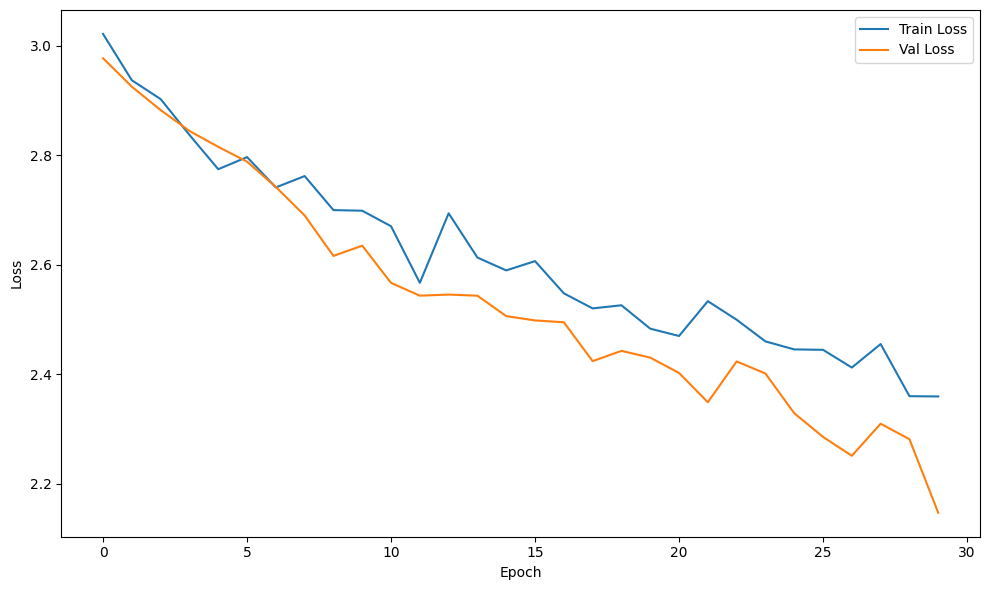

In [286]:
plt.figure(figsize=(10,6))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses,   label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss")
#plt.yscale('log')
plt.legend(); plt.tight_layout(); plt.show()


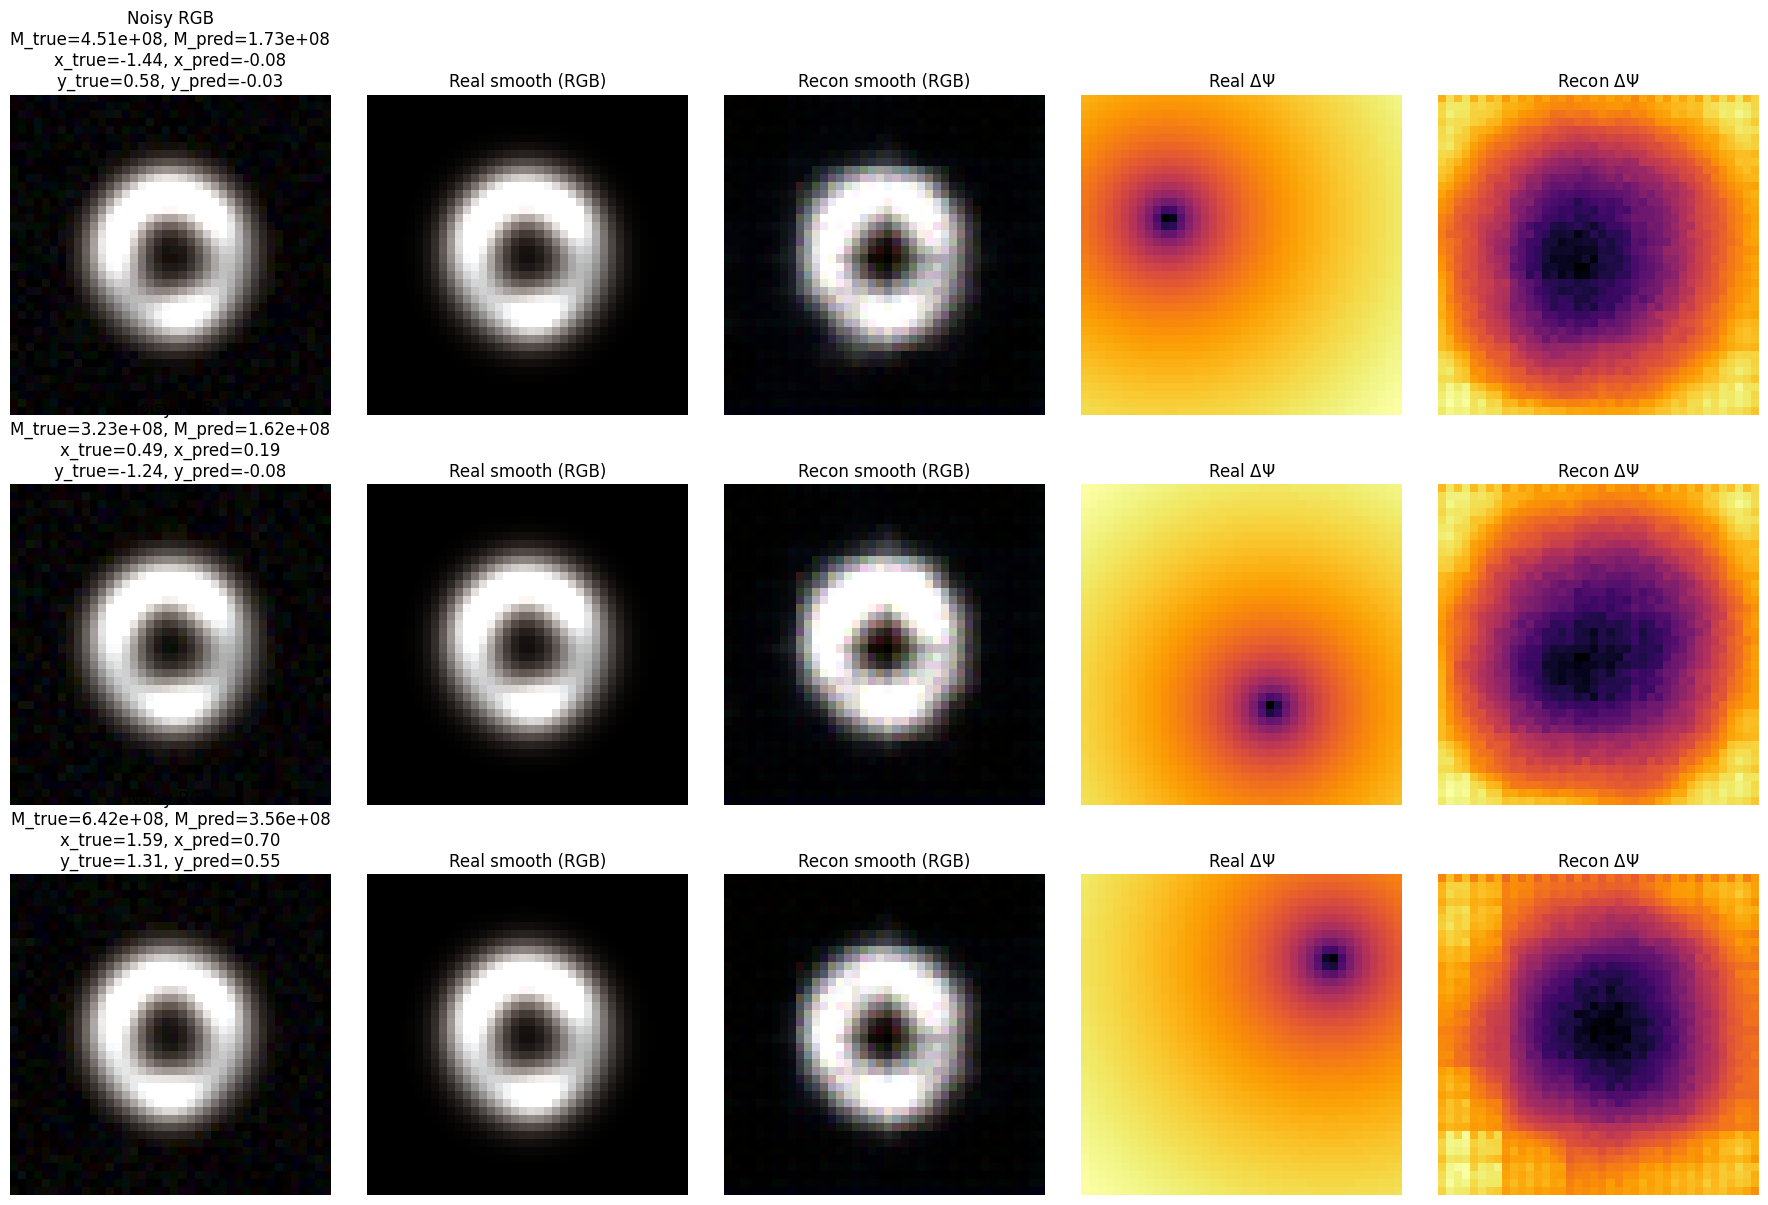

In [287]:
# === Desnormalización de mxy y Δψ ===
mean_Y2 = norm_stats["mean_Y2"]
std_Y2  = norm_stats["std_Y2"]

mean_mxy = np.array([norm_stats["mean_mass"], norm_stats["mean_x"], norm_stats["mean_y"]])
std_mxy  = np.array([norm_stats["std_mass"],  norm_stats["std_x"],  norm_stats["std_y"]])

# Desnormalizar predicciones y ground truth
mxy_pred_np_denorm = mxy_pred_np * std_mxy + mean_mxy
mxy_true_np_denorm = mxy_true_np * std_mxy + mean_mxy

y_pred_d_np_denorm = y_pred_d_np * std_Y2 + mean_Y2
y_true_d_np_denorm = y_true_d_np * std_Y2 + mean_Y2

# === Visualización en TEST con manejo robusto de ejes y tamaños ===
model.eval()
with torch.no_grad():
    x, y_true_smooth, y_true_delta, mxy_true = next(iter(test_loader))
    x, y_true_smooth, y_true_delta, mxy_true = (
        x.to(device),
        y_true_smooth.to(device),
        y_true_delta.to(device),
        mxy_true.to(device),
    )
    y_pred_smooth, y_pred_delta, mu, logvar, mxy_pred = model(x)

# A CPU + NumPy
x_np         = x.detach().cpu().numpy()
y_true_s_np  = y_true_smooth.detach().cpu().numpy()
y_true_d_np  = y_true_delta.detach().cpu().numpy()
y_pred_s_np  = y_pred_smooth.detach().cpu().numpy()
y_pred_d_np  = y_pred_delta.detach().cpu().numpy()
mxy_true_np  = mxy_true.detach().cpu().numpy()
mxy_pred_np  = mxy_pred.detach().cpu().numpy()

# Parámetros de muestreo
offset    = 0
max_rows  = 3
N         = x_np.shape[0]
n_samples = max(1, min(max_rows, N - offset))

# Crear figura
fig, axes = plt.subplots(n_samples, 5, figsize=(18, 4 * n_samples))
if n_samples == 1:
    axes = np.array(axes).reshape(1, 5)

for i in range(n_samples):
    idx = i + offset

    # Valores de regresión desnormalizados
    m_true, x_true, y_true = mxy_true_np_denorm[idx]
    m_pred, x_pred, y_pred = mxy_pred_np_denorm[idx]

    # Col 0: Entrada ruidosa (RGB)
    ax = axes[i, 0]
    ax.imshow(np.clip(x_np[idx].transpose(1, 2, 0), 0, 1))
    ax.set_title(
        f"Noisy RGB\n"
        f"M_true={m_true:.2e}, M_pred={m_pred:.2e}\n"
        f"x_true={x_true:.2f}, x_pred={x_pred:.2f}\n"
        f"y_true={y_true:.2f}, y_pred={y_pred:.2f}"
    )
    ax.axis('off')

    # Col 1: Smooth real (RGB)
    ax = axes[i, 1]
    ax.imshow(np.clip(y_true_s_np[idx].transpose(1, 2, 0), 0, 1))
    ax.set_title("Real smooth (RGB)")
    ax.axis('off')

    # Col 2: Smooth recon (RGB)
    ax = axes[i, 2]
    ax.imshow(np.clip(y_pred_s_np[idx].transpose(1, 2, 0), 0, 1))
    ax.set_title("Recon smooth (RGB)")
    ax.axis('off')

    # Col 3: Δψ real
    ax = axes[i, 3]
    ax.imshow(y_true_d_np_denorm[idx, 0], origin='lower', cmap='inferno')
    ax.set_title(r"Real $\Delta\Psi$")
    ax.axis('off')

    # Col 4: Δψ recon
    ax = axes[i, 4]
    ax.imshow(y_pred_d_np_denorm[idx, 0], origin='lower', cmap='inferno')
    ax.set_title(r"Recon $\Delta\Psi$")
    ax.axis('off')

plt.tight_layout()
plt.show()


In [288]:
print("X", X_train.min().item(), X_train.max().item())
print("Y1", Y1_train.min().item(), Y1_train.max().item())
print("Y2", Y2_train.min().item(), Y2_train.max().item())


X 0.0 1.0
Y1 1.5442640943774677e-08 1.0
Y2 -4.214349269866943 2.489509344100952


In [289]:
print("x:", x.min().item(), x.max().item())
print("s_pred:", s_pred.min().item(), s_pred.max().item())
print("y_s (GT):", y_s.min().item(), y_s.max().item())
print("d_pred:", d_pred.min().item(), d_pred.max().item())
print("y_d (GT):", y_d.min().item(), y_d.max().item())


x: 0.0 1.0
s_pred: -0.09436357766389847 1.6198240518569946
y_s (GT): 1.5442640943774677e-08 1.0
d_pred: -1.0880703926086426 1.1589077711105347
y_d (GT): -4.174844264984131 2.3322033882141113


In [290]:
x, y_s, y_d, mxy = next(iter(train_loader))
print("x:", x.shape, x.min().item(), x.max().item())
print("y_s:", y_s.shape, y_s.min().item(), y_s.max().item())
print("y_d:", y_d.shape, y_d.min().item(), y_d.max().item())
print("mxy:", mxy.shape, mxy.mean(dim=0), mxy.std(dim=0))


x: torch.Size([64, 3, 40, 40]) 0.0 1.0
y_s: torch.Size([64, 3, 40, 40]) 1.5442640943774677e-08 1.0
y_d: torch.Size([64, 1, 40, 40]) -4.097208499908447 2.385650396347046
mxy: torch.Size([64, 3]) tensor([0.2004, 0.0659, 0.1283]) tensor([1.1187, 0.9484, 0.9771])
